# Progetto di Computer Vision 

In questo progetto effettuiamo una classificazione di Polline e Polveri, il Dataset è stato fornito dal professore Sebastiano Battiato.

## Struttura del Dataset 

Nel Dataset Fornito abbiamo 2 Cartelle principali 
1. TRAIN_CV contiene tutte le immagini da utilizzare per l'allenamento del classificatore 
2. TEST_CV tutte le immagini del Test Set per validare il classificatore.

Si sfrutteranno tecniche di Machine Learning per adattare e migliorare il piu possibile il classificatore 

## Struttura del TRAIN_CV 
Nella Cartella **Train_Cv** sono presenti 4 classi:

1. Corylus avellana – ben sviluppati
2. Corylus avellana – anomali
3. Alnus – ben sviluppati
4. Debris (bolle, polvere, oggetti non polline)

Queste classi rappresentano i 4 tipi di polveri catturate dai sensori tra cui pollini da dover classificare correttamente; vediamo che vi è una classe nello specifico **Corylus avellana** che ha presente dei pollini che sono anomali. **Debris** racchiude tutti gli oggetti che non sono polline come polvere ecc..\

Ogni classe poi ha 3 sotto cartelle che sono:
1. train_MASK ---> sono presenti delle maschere binarie che permettono di comprendere dove finesce l'oggetto (1) e dove inizia lo sfondo (2)
2. train_OBJ ---> immagine reale dell'oggetto
3. train_SEGM ---> segmentazione piu dettagliata (bordi, parti intere dell'oggetto).

queste sono le 3 classi che ci aiuteranno per effettuare il task.

In [20]:
# import necessari per Analisi Dataset

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import random

# import per modello di ML 
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from collections import defaultdict

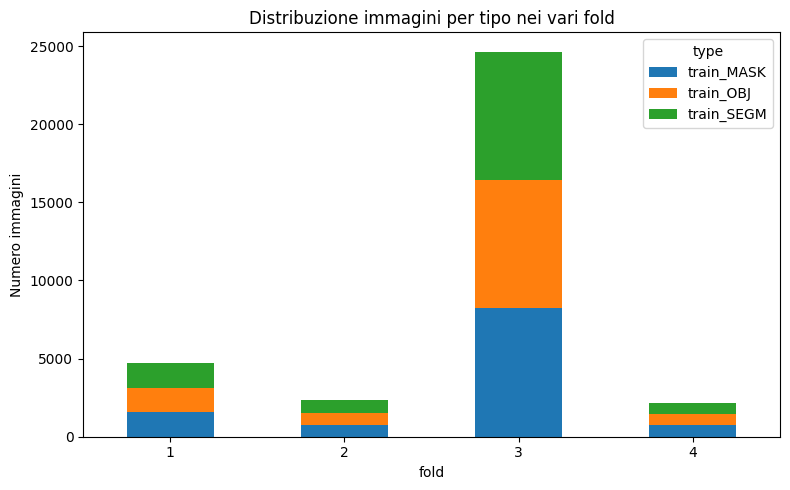

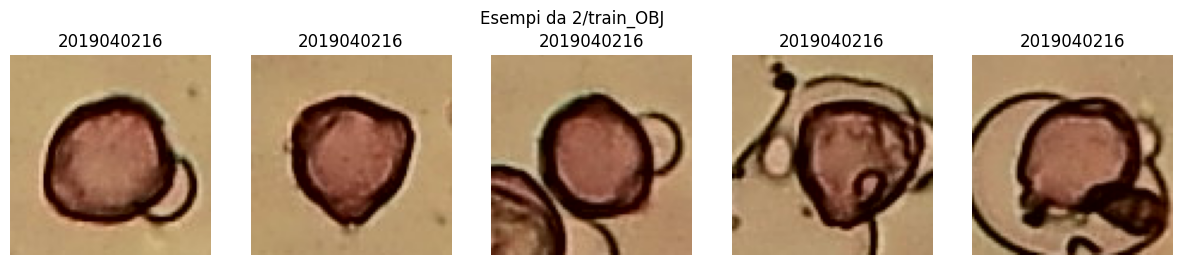

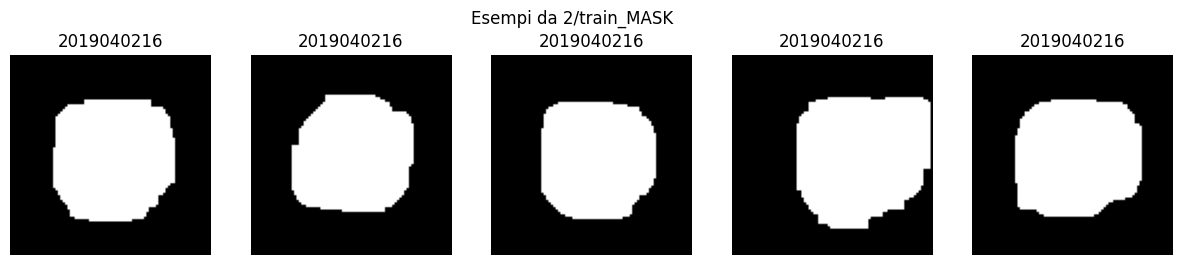

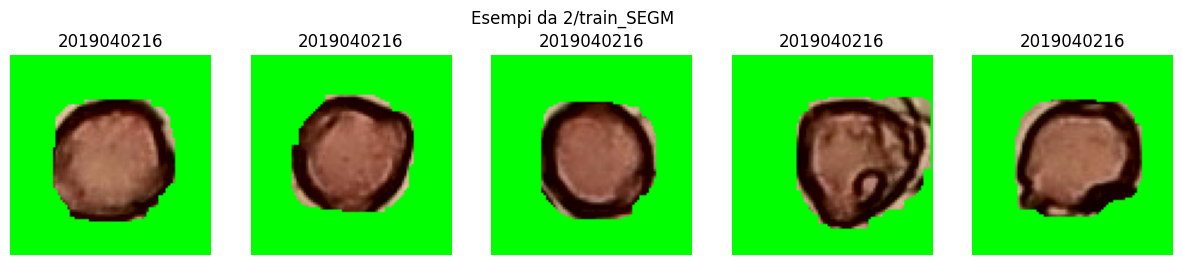

In [21]:
# funzione per far vedere qualche esempio:
def show_examples(fold='1', img_type='train_OBJ', n=5):
    folder = os.path.join(root, fold, img_type)
    files = os.listdir(folder)[:n]
    fig, axs = plt.subplots(1, n, figsize=(n*3, 3))
    for i, f in enumerate(files):
        img = Image.open(os.path.join(folder, f))
        axs[i].imshow(np.array(img), cmap='gray' if img_type=='train_MASK' else None)
        axs[i].axis('off')
        axs[i].set_title(f[:10])
    plt.suptitle(f'Esempi da {fold}/{img_type}')
    plt.show()

def show_high_var_examples(fold, top_n=5):
    selected = intra_df[intra_df['fold'] == fold].sort_values(by='std', ascending=False).head(top_n)
    fig, axs = plt.subplots(1, top_n, figsize=(top_n*3, 3))
    for i, row in enumerate(selected.itertuples()):
        img = Image.open(os.path.join(root, fold, 'train_OBJ', row.filename))
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"{row.std:.1f}")
        axs[i].axis('off')
    plt.suptitle(f'Esempi con alta varianza - Fold {fold}')
    plt.show()



root = 'TRAIN_CV' # cartella pricnipale di train 
folds = ['1', '2', '3', '4']
types = ['train_MASK', 'train_OBJ', 'train_SEGM']


rows = []
for fold in folds:
    fold_path = os.path.join(root, fold)
    for img_type in types:
        path = os.path.join(fold_path, img_type)
        if not os.path.exists(path):
            continue
        for file in os.listdir(path):
            if file.endswith('.png'):
                rows.append({
                    'fold': fold,
                    'type': img_type,
                    'filename': file
                })

df = pd.DataFrame(rows)
summary = df.groupby(['fold', 'type']).size().unstack().fillna(0).astype(int)


summary.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Distribuzione immagini per tipo nei vari fold')
plt.ylabel('Numero immagini')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



show_examples('2', 'train_OBJ')
show_examples('2', 'train_MASK')
show_examples('2', 'train_SEGM')

# Spiegazione Output Grafico a BIN 

Possiamo vedere che nelle 4 classi il numero di osservazioni è bilanciato visualizzando il bin in particolare abbiamo ottenuto che in ogni classe abbiamo un numero di osservazioni pari ad:                           
1.           1566       1566        1566
2.           773        773         773
3.          8216       8216        8216
4.           724        724         724


Questo fa capire che la classe piu numerosa è la **terza classe**, a seguito la **prima** poi la **seconda** e poi infine la **quarta**. Abbiamo quindi la maggior parte del polline che è stata catturata dai sensori è stata ben sviluppata.

# Analisi Esplorativa 

In [22]:
print("Numero totale immagini:")
print(df['type'].value_counts())
print("--------------------------")

print("Numero immagini per classe:")
print(df['fold'].value_counts())
print("--------------------------")

print("Numero immagini per classe + tipo:")
class_type_counts = df.groupby(['fold', 'type']).size().unstack().fillna(0).astype(int)
display(class_type_counts)
print("--------------------------")

print("Immagini duplicate")
duplicate_names = df.duplicated(subset='filename', keep=False)
duplicates_df = df[duplicate_names].sort_values('filename')
print("Immagini duplicate su più fold o tipi:")
print(duplicates_df)



Numero totale immagini:
type
train_MASK    11279
train_OBJ     11279
train_SEGM    11279
Name: count, dtype: int64
--------------------------
Numero immagini per classe:
fold
3    24648
1     4698
2     2319
4     2172
Name: count, dtype: int64
--------------------------
Numero immagini per classe + tipo:


type,train_MASK,train_OBJ,train_SEGM
fold,,,
1,1566,1566,1566
2,773,773,773
3,8216,8216,8216
4,724,724,724


--------------------------
Immagini duplicate
Immagini duplicate su più fold o tipi:
Empty DataFrame
Columns: [fold, type, filename]
Index: []


# Intensita di Colore per immagine 

Viene fatto questo studio per valutare se all'interno del dataset vi sono immagini corrotte, questo è visibile in base al valore della media:
- Se esso tende a 0 allora vi sono immagini troppo scure.
- Se esso tende a 255 allora vi sono delle immagini troppo chiare.

Inoltre siccome abbiamo diversi classi [1,2,3,4] vogliamo vedere le caratteristiche se sono simili tra di loro in modo da verificare la qualità dei dati per ogni singolo fold.

Grazie ai valori di output possiamo comprendere se deve essere fatta una normalizzazione o i dati sono gia adeguati per i modelli di classificazione o no.

Se un dataset contenesse un Deviazione standard molto bassa potrebbe essere indicativo di immagini poco informative.


## Interpretazione dei dati:

Tutti i fold hanno media compresa tra 128 e 141 che è accettabile (scala 0 -> 255).
- Fold 4 ha media più bassa e Deviazione Standard piu alta, ciò indica variazioni estreme all'interno delle immagini.

In [23]:
intensity_stats = []
for row in df[df['type'] == 'train_OBJ'].itertuples(): # intero per train_OBJ
    path = os.path.join(root, row.fold, 'train_OBJ', row.filename) # percorso dell'img
    img = Image.open(path).convert('L') # convert in gray
    arr = np.array(img) # array numpy 
    intensity_stats.append({
        'fold': row.fold,
        'mean_intensity': arr.mean(),#statistiche 
        'std_intensity': arr.std()
    })

pd.DataFrame(intensity_stats).groupby('fold')[['mean_intensity', 'std_intensity']].describe() 

# statistiche rappresentate sono media dev std minimo massimo e i 4 quartili.


mean_intensity                                                            \
              count        mean        std        min         25%         50%   
fold                                                                            
1            1566.0  133.118697  11.989896  92.312642  125.889846  134.596868   
2             773.0  140.776948  12.120601  86.851616  133.014314  142.183248   
3            8216.0  139.253048  10.629171  82.247449  132.871528  140.469529   
4             724.0  128.321295  23.569681  41.941610  120.354982  134.578160   

                             std_intensity                                   \
             75%         max         count       mean        std        min   
fold                                                                          
1     142.136054  160.812358        1566.0  54.597538   4.598815  39.017719   
2     150.049036  165.147959         773.0  51.624063   6.291771  32.929795   
3     146.832129  166.185516        8216.0  53.650777   4.772645  31.907512   
4     143.790072  166.556548         724.0  50.160044  13.105867  24.923170   

                                                  
            25%        50%        75%        max  
fold                                              
1     51.657339  54.664890  57.649152  73.625923  
2     47.129519  51.401426  55.755334  80.399376  
3     50.406819  53.653620  56.769816  75.556620  
4     39.577409  48.190706  59.593697  85.571209

# Analisi Statistiche RGB 
Questa analisi permette di valutare se vi sono immagini sbilanciate verso un canale di colore,  approccio utile per vedere sei nei 4 fold troviamo differenze di colore significative per le immagini.

- le differenze di colore significative possono creare del bias all'interno del modello di classificazione.
- comprendere dove fare la normalizzazione (se globale o per un fold specifico)
- Visualizziamo la presenza di valori anomali all'intenro delle immagini per quanto riguarda la distribuzione del colore.

-------------------------------------------------------------------------------------------------------------------

## Interpretazione dei Risultati

Valori come output sono 6 r_mean g_mean b_mean r_std g_std b_std 

- Fold 1: Media (RGB) <---> (157,127,89)
Varianza Bassa = Immagini Omogenee
Fold Ben Bilanciato 

- Fold 2: Media (RGB) <---> (165,137,96)
Canali piu luminosi del Fold 1 (valori di RGB più alti)

- Fold 3: Media (RGB) <------> (164, 135, 94)
Buona consistenza del fold 

- Fold 4: Media (RGB) <-----> (150, 125, 87)
Deviazione standard piu alta in tutti i canali 

-------------------------------------------------------------------------------------------------------------------

### Motivazione su Fold 4:

Questo fold rappresenta tutti gli oggetti catturati che non sono polline perciò la deviaizone standard alta è giustificata, dato che tutto ciò che non è polline viene racchiuso in questa classe, e comprendendo diversi oggetti (non tutti simili tra loro) la devizione standard è alta.

- Utilità: In questo modo possiamo comprendere quali sono le caratteristiche che racchiudono tutti gli oggetti che non sono polline.



In [24]:
color_stats = []
for row in df[df['type'] == 'train_OBJ'].itertuples():
    path = os.path.join(root, row.fold, 'train_OBJ', row.filename)
    img = np.array(Image.open(path))
    if img.ndim == 3:
        r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        color_stats.append({
            'fold': row.fold,
            'r_mean': r.mean(), 'g_mean': g.mean(), 'b_mean': b.mean(),
            'r_std': r.std(), 'g_std': g.std(), 'b_std': b.std()
        })

pd.DataFrame(color_stats).groupby('fold')[['r_mean', 'g_mean', 'b_mean']].describe()


r_mean                                                             \
       count        mean        std         min         25%         50%   
fold                                                                      
1     1566.0  157.428365  11.989080  112.331349  150.054705  158.631874   
2      773.0  164.907864  12.000088  111.031321  157.465136  165.989371   
3     8216.0  163.573454  10.786882  105.816468  157.195791  164.798540   
4      724.0  150.736410  26.436562   57.258929  142.720486  158.639881   

                              g_mean              ...                          \
             75%         max   count        mean  ...         75%         max   
fold                                              ...                           
1     166.288797  183.566327  1566.0  129.270809  ...  138.638464  159.309524   
2     174.260204  188.936508   773.0  137.218802  ...  146.998866  163.261480   
3     171.298151  190.472931  8216.0  135.714112  ...  143.623795  164.720663   
4     168.233099  190.516723   724.0  124.878413  ...  140.596584  164.177721   

      b_mean                                                         \
       count       mean        std        min        25%        50%   
fold                                                                  
1     1566.0  89.278461   8.896810  59.490079  83.597045  90.008999   
2      773.0  95.911193   9.054264  58.109127  90.140023  96.500283   
3     8216.0  93.772648   8.203140  51.568169  88.870359  94.801375   
4      724.0  87.503496  17.119793  23.942035  81.072031  92.504889   

                              
             75%         max  
fold                          
1      96.036777  108.748866  
2     102.991213  114.700964  
3      99.626842  113.561933  
4      99.350872  116.636763  

[4 rows x 24 columns]

# Studio Varianza Intra-Classe 
La varianza intraclasse in questo caso serve per rafforzare le nostre supposizioni precedenti.
Utilizziamo il BoxPlot che ci permette di valutare la varianza complessiva per ogni fold e valutarne l'importanza per un futuro training del modello.

-------------------------------------------------------------------------------------------------------------------

## Interpretazione dei Risultati del Box-Plot:

Cosa Mostra il Box-Plot

- Centro del box: mediana della deviazione standard
- Altezza del box: distribuzione interquartile (IQR → 25°–75° percentile)
- Barre (whiskers): range accettabile
- Pallini: outlier (immagini molto diverse)


### Fold 1 2 3

- Mediana attorno a ~55–57
- Deviazione contenuta → immagini coerenti tra loro
- Alcuni outlier, ma gestibili

Questi fold sono bilanciati in termini di varianza: buoni per training o validazione.


### Fold 4

- Mediana più bassa (≈50)
- Box molto più alto → alta dispersione nella deviazione standard
- Estensione verso il basso (std ≈ 30) e verso l’alto (fino a >80)
- Molti outlier



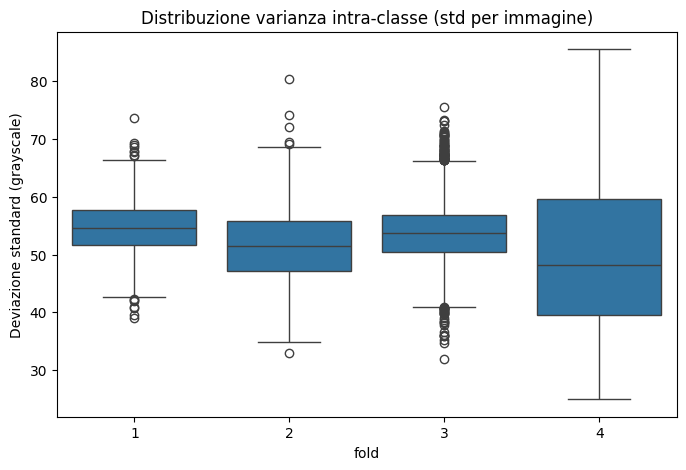

In [25]:
intra_var = []
for row in df[df['type'] == 'train_OBJ'].itertuples():
    path = os.path.join(root, row.fold, 'train_OBJ', row.filename)
    img = np.array(Image.open(path).convert('L'))
    intra_var.append({
        'fold': row.fold,
        'filename': row.filename,
        'std': img.std()
    })

intra_df = pd.DataFrame(intra_var)

# Boxplot per fold
plt.figure(figsize=(8,5))
sns.boxplot(data=intra_df, x='fold', y='std')
plt.title("Distribuzione varianza intra-classe (std per immagine)")
plt.ylabel("Deviazione standard (grayscale)")
plt.show()

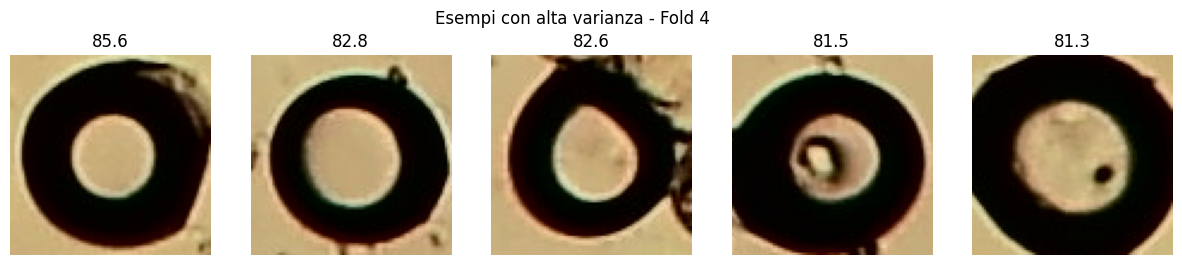

In [26]:
show_high_var_examples('4')

# Modello 

In [13]:
    
"""
- Il costruttore: La classe inizializza una lista samples che conterrà i dati e la transform che 
viene utilizzata per la DataAugmentation, fa il caricamento dei dati per ogni fold, crea i percorsi per maschera e oggetto 
crea il dizionario che ha come utilizzo principale trovare la maschera associata all'oggetto, estraendo informazioni dal nome delle immagini.
Stampera il numero di immagini che contengono associazione ( maschera <----> oggetto)...

- getitem: Come metodo ulteriore della classe, 
"""


# Dataset e PreProcess
class Dataset_Polline(Dataset):
    def __init__(self, root, folds_to_include, transform=None):
        self.samples = []
        self.transform = transform

        for fold in folds_to_include:
            obj_dir = os.path.join(root, fold, 'train_OBJ')
            mask_dir = os.path.join(root, fold, 'train_MASK')
            if not os.path.exists(obj_dir) or not os.path.exists(mask_dir):
                continue

            mask_files = {f.split('MASK_')[-1] if 'MASK_' in f else f: f for f in os.listdir(mask_dir)}

            count_added = 0
            for fname in os.listdir(obj_dir):
                if not fname.endswith('.png'):
                    continue
                key = fname.split('OBJ_')[-1] if 'OBJ_' in fname else fname
                if key in mask_files:
                    self.samples.append({
                        'img_path': os.path.join(obj_dir, fname),
                        'mask_path': os.path.join(mask_dir, mask_files[key]),
                        'label': int(fold) - 1
                    })
                    count_added += 1
                else:
                    print(f"[SALTO] Nessuna maschera corrispondente per: {fname}")
            print(f"[INFO] Fold {fold}: {count_added} immagini valide aggiunte\n")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = Image.open(sample['img_path']).convert('RGB')
        mask = Image.open(sample['mask_path']).convert('L')

        img = T.ToTensor()(img)
        mask = T.ToTensor()(mask)
        img = img * (mask > 0)

        if self.transform:
            img = self.transform(img)

        return img, sample['label']
    


"""
- 
- 
- 

"""
class TestDatasetNoLabel(Dataset):
    def __init__(self, test_dir, transform=None):
        self.paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = T.ToTensor()(img)
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)


In [14]:
# Trasformazioni
"""
Queste trasformazioni servono per effettuare poi la dataAugmentation passando il transform nel 
costruttore della classe, come sono state pensate..

1. Trasformazioni nel training con Flip e Rotazioni, utile anche per CREARE ulteriori ossservazioni che verranno 
salvate nei loader in modo da avere le classi bilanciate. Inoltre riesco ad introdurre delle complessità nel trianing 

2. Normalizzazione nel Test Set: la Normalizzazione semplice è stata fatta per il test set, questo perchè il test è 
diviso in due tipi

- Primo Test: Usando il 4 fold come test set per vedere come il modello riesce a classificare il rumore 
- Secondo Test: Utilizzare l'intero TEST SET fornito dal professore.

"""
train_transform = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.Normalize([0.5]*3, [0.25]*3)
])

val_transform = T.Compose([
    T.Resize((128, 128)),
    T.Normalize([0.5]*3, [0.25]*3)
])


In [15]:
"""
Creati i dataset con i trasformer per train e validation viene fatto anche uno shuffling dei dati per evitare 
che si creino pattern all'interno del training set.

"""


# Datasets e split
full_dataset = Dataset_Polline("TRAIN_CV", folds_to_include=['1', '2', '3'])
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
indices = list(range(len(full_dataset)))
random.shuffle(indices)
train_indices, val_indices = indices[:train_size], indices[train_size:]


train_dataset = Dataset_Polline("TRAIN_CV", ['1', '2', '3'], transform=train_transform)
val_dataset = Dataset_Polline("TRAIN_CV", ['1', '2', '3'], transform=val_transform)

# spiegazione output per simo: se vedi [INFO] sono il numero di immagini matchate con le maschere per ogni fold 
# ES: Fold 1: 1566 immagini valide aggiunte nel Fold 1 ci sono 1566 immagini di oggetti che sono state associate 
# alle maschere ecc..

# NB: vengono stampate due volte perchè la print è nel costruttore del Dataset_Polline e l'ho invocato per due volte 
# una per ogni set (NEL TRAINING FACCCIO TRASFORMAZIONI nel VALIDATION NO).


In [16]:

# Etichette
train_labels = [train_dataset[i][1] for i in train_indices] # estraggo etihetta dal dizionario 

class_counts = Counter(train_labels) # conto il numero di osservazioni per classe 

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()} 
# Inversi dei pesi piu osservazioni pesi minori meno frequenti pesi maggiori 


# Sampling bilanciato: privilegia le classi poco presenti in modo da poter effettuare predizioni corrette..
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels), replacement=True)


# creo i set tramite Subset (gia sono stati "Trasformati")
train_set = torch.utils.data.Subset(train_dataset, train_indices)
val_set = torch.utils.data.Subset(val_dataset, val_indices)

#DataAugmented per poi bilanciare il numero di campioni utilizzando sampler che bilancia le classi 
train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=32)



# Fold 4 come test senza trasformazioni solo normazilazzione 
test_dataset = Dataset_Polline("TRAIN_CV", folds_to_include=['4'], transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# Test non etichettato senzs trasformazioni solo normalizzazione
testcv_dataset = TestDatasetNoLabel("TEST_CV", transform=val_transform)
testcv_loader = DataLoader(testcv_dataset, batch_size=32)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
""" Funzione per vedere se il numero di ossevazioni utilizzate nel loader (che verrà passato nel train) è bilanciato."""

def count_labels_from_loader(loader):
    label_counter = defaultdict(int)
    for imgs, labels in loader:
        for label in labels:
            label_counter[label.item()] += 1
    return label_counter

label_map = {0: 'Corylus_normal', 1: 'Corylus_anomalo', 2: 'Alnus', 3: 'Debris'}
sampled_counts = count_labels_from_loader(train_loader)
print("Distribuzione approssimativa delle classi nel train_loader:")
for lbl, count in sampled_counts.items():
    print(f"  ➤ Classe {label_map[lbl]}: {count} campioni")


Distribuzione approssimativa delle classi nel train_loader:
  ➤ Classe Corylus_normal: 2854 campioni
  ➤ Classe Corylus_anomalo: 2802 campioni
  ➤ Classe Alnus: 2788 campioni


In [40]:
# Modello
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:

# Allenamento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, loader):
    model.train()
    correct, total, loss_total = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return loss_total / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    loss_total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    return loss_total / len(loader), acc, y_true, y_pred

train_accs, val_accs, train_losses, val_losses = [], [], [], []
for epoch in range(1, 11):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}: Train acc={train_acc:.3f}, Val acc={val_acc:.3f}, Train loss={train_loss:.4f}, Val loss={val_loss:.4f}")


Epoch 1: Train acc=0.879, Val acc=0.911, Train loss=0.3256, Val loss=0.2506
Epoch 2: Train acc=0.925, Val acc=0.938, Train loss=0.2097, Val loss=0.1990
Epoch 3: Train acc=0.936, Val acc=0.939, Train loss=0.1612, Val loss=0.2314
Epoch 4: Train acc=0.948, Val acc=0.940, Train loss=0.1319, Val loss=0.2112
Epoch 5: Train acc=0.959, Val acc=0.933, Train loss=0.1079, Val loss=0.2440
Epoch 6: Train acc=0.963, Val acc=0.895, Train loss=0.0998, Val loss=0.3255
Epoch 7: Train acc=0.970, Val acc=0.927, Train loss=0.0851, Val loss=0.2390
Epoch 8: Train acc=0.972, Val acc=0.946, Train loss=0.0746, Val loss=0.2268
Epoch 9: Train acc=0.976, Val acc=0.939, Train loss=0.0635, Val loss=0.2319
Epoch 10: Train acc=0.977, Val acc=0.928, Train loss=0.0617, Val loss=0.2793


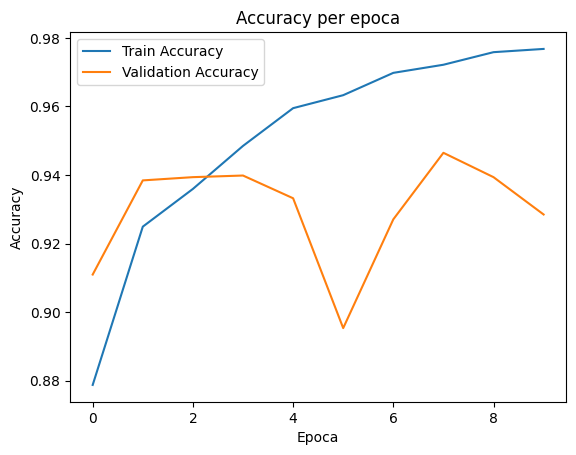

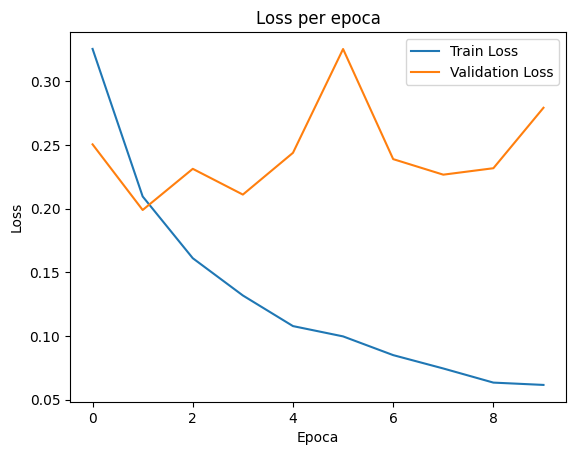

                 precision    recall  f1-score   support

 Corylus_normal       0.83      0.84      0.84       341
Corylus_anomalo       0.83      0.93      0.88       160
          Alnus       0.96      0.95      0.95      1610

       accuracy                           0.93      2111
      macro avg       0.87      0.90      0.89      2111
   weighted avg       0.93      0.93      0.93      2111



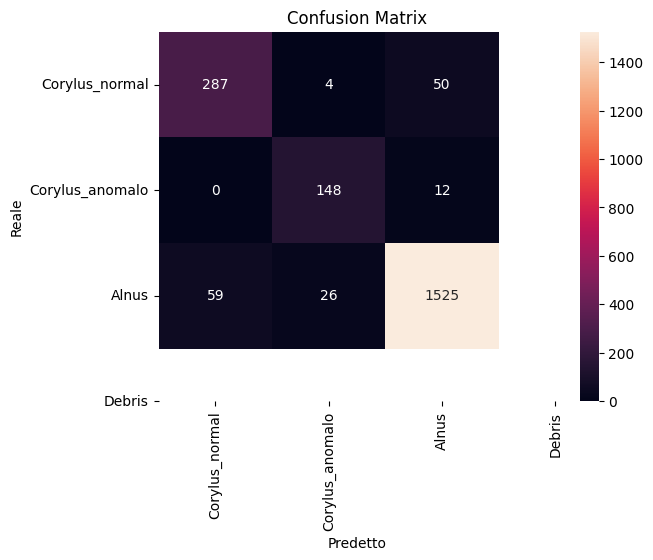

In [43]:
# Plot
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoca")
plt.legend()
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.title("Loss per epoca")
plt.legend()
plt.show()

# Matrix di confusione
print(classification_report(y_true, y_pred, target_names=['Corylus_normal', 'Corylus_anomalo', 'Alnus']))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Corylus_normal', 'Corylus_anomalo', 'Alnus', 'Debris'], yticklabels=['Corylus_normal', 'Corylus_anomalo', 'Alnus', 'Debris'])
plt.title("Confusion Matrix")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

